In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Read the dataset
df = pd.read_csv("Suicide_Detection.csv")
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
# Text preprocessing
def preprocess_text(text):
    # Clean punctuations and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Convert all blanks and breaks into a single space
    processed_text = ' '.join(tokens)
    return processed_text

df['text'] = df['text'].apply(preprocess_text)

In [4]:
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [5]:
df['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [6]:
# Split dataset into features and target variable
X = df['text']  
y = df['class']


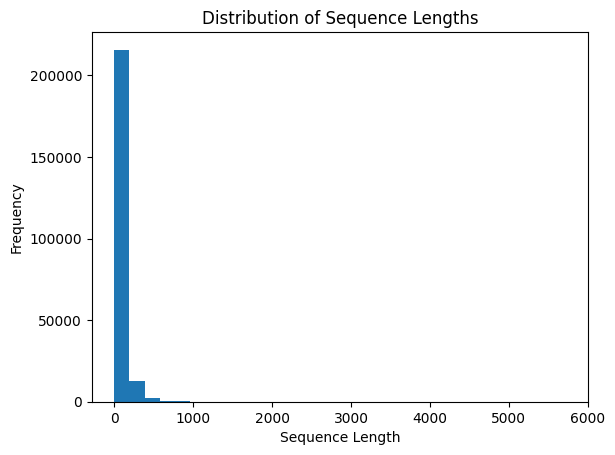

In [8]:
# Find the lengths of sequences in the dataset
sequence_lengths = [len(seq.split()) for seq in X]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [9]:

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)

(185659,)


In [11]:

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1300)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [12]:
# Check number of features used in TF-IDF vectorization
print("Number of features used in TF-IDF vectorization:", len(tfidf_vectorizer.get_feature_names_out()))

Number of features used in TF-IDF vectorization: 1300


In [13]:
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

# Function to generate document embeddings using FastText
def generate_document_embeddings(text, fasttext_model):
    document_embeddings = []
    for sentence in text:
        word_embeddings = [fasttext_model[word] for word in sentence.split() if word in fasttext_model]
        if len(word_embeddings) > 0:
            document_embeddings.append(np.mean(word_embeddings, axis=0))
        else:
            document_embeddings.append(np.zeros(300))  # Use zeros for out-of-vocabulary words
    return np.array(document_embeddings)




In [21]:
# Generate document embeddings for training and test data
X_train_embeddings = generate_document_embeddings(X_train, fasttext_model)
X_test_embeddings = generate_document_embeddings(X_test, fasttext_model)


# Print shapes of TF-IDF vectors and FastText embeddings
print("Shape of TF-IDF vectors:", X_train_tfidf.shape)
print("Shape of FastText embeddings:", X_train_embeddings.shape)

# Concatenate TF-IDF vectors and FastText embeddings
X_train_combined = np.concatenate((X_train_tfidf.toarray(), X_train_embeddings), axis=1)
X_test_combined = np.concatenate((X_test_tfidf.toarray(), X_test_embeddings), axis=1)

# Print shapes of combined feature vectors
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)


Shape of TF-IDF vectors: (185659, 1300)
Shape of FastText embeddings: (185659, 300)
Shape of X_train_combined: (185659, 1600)
Shape of X_test_combined: (46415, 1600)


In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# XGBoost classification with combined feature vectors
model = xgb.XGBClassifier(learning_rate=0.05, max_depth=5, objective='binary:logistic', n_estimators=600)
model.fit(X_train_combined, y_train_encoded)
y_pred_train = model.predict(X_train_combined)
y_pred_test = model.predict(X_test_combined)

In [23]:
# Performance evaluation
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test_encoded, y_pred_test)
train_f1 = f1_score(y_train_encoded, y_pred_train, average='weighted')
test_f1 = f1_score(y_test_encoded, y_pred_test, average='weighted')

In [24]:
# Confusion Matrix
train_conf_matrix = confusion_matrix(y_train_encoded, y_pred_train)
test_conf_matrix = confusion_matrix(y_test_encoded, y_pred_test)

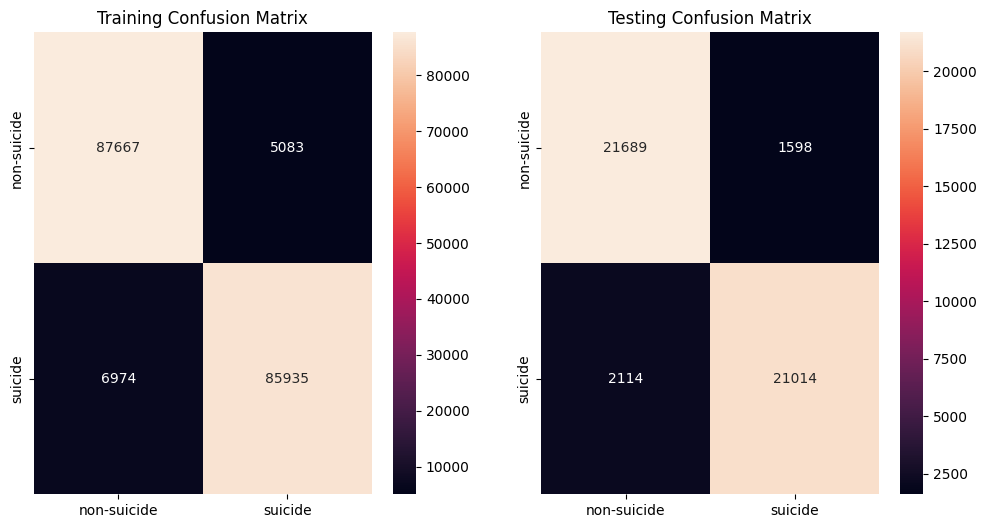

In [25]:
# Plot Confusion Matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', ax=axes[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', ax=axes[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Training Confusion Matrix')
axes[1].set_title('Testing Confusion Matrix')
plt.show()

In [26]:
# Print performance metrics
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Training F1 Score:", train_f1)
print("Testing F1 Score:", test_f1)


Training Accuracy: 0.9350583596809204
Testing Accuracy: 0.9200258537110848
Training F1 Score: 0.9350521884975032
Testing F1 Score: 0.9200129213376587


In [27]:
joblib.dump((model, tfidf_vectorizer), 'xgboost_model_with_fasttext_and_tfidf.pkl')

['xgboost_model_with_fasttext_and_tfidf.pkl']

In [28]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
# Convert text data to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [30]:
# Padding sequences to make them of equal length
max_length = 1000
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

In [31]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

In [32]:
# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10


  33/2901 [..............................] - ETA: 6:50:08 - loss: 0.6936 - accuracy: 0.5208

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000028B29710310>>
Traceback (most recent call last):
  File "c:\xampp\htdocs\SUICIDE DETECTION\myenv\lib\site-packages\ipykernel\ipkernel.py", line 783, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test_encoded)
print("LSTM Test Accuracy:", lstm_accuracy)

In [ ]:

# Save the LSTM model
lstm_model.save("lstm_model.h5")

In [ ]:
# Build GRU model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the GRU model
gru_history = gru_model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test_encoded))

In [ ]:
# Evaluate GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test_padded, y_test_encoded)
print("GRU Test Accuracy:", gru_accuracy)


In [ ]:

# Save the GRU model
gru_model.save("gru_model.h5")